<b><font color="SteelBlue" size="+3">Classifiez automatiquement des biens de consommation</font></b>

# Introduction

Ce notebook est la suite de celui sur le traitement des descriptions. On récupère les données nettoyées pour les catégories des produits.

## Imports

In [1]:
# Chargement des librairies
# Standard
import os

# Data Manipulation and Analysis
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing
from matplotlib.image import imread
from PIL import Image as PilImage

# Deep Learning - TensorFlow/Keras
os.environ["KERAS_BACKEND"] = "torch"
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as preprocess_inceptionresnetv2
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet201
from tensorflow.keras.utils import to_categorical

# Custom Modules
from Deveau_Estelle_4_IMG_func_042024 import *

## Data

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'data',
 'Deveau_Estelle_1_notebook_txt_faisabilite_042024.ipynb',
 'Deveau_Estelle_2_NLP_func_042024.py',
 'Deveau_Estelle_3_notebook_img_faisabilite_042024.ipynb',
 'Deveau_Estelle_4_IMG_func_042024.py',
 'Deveau_Estelle_5_notebook_img_classification_042024.ipynb',
 'model_augmented_best.weights.h5',
 'model_augmented_data_best.weights.h5',
 'model_augmented_data_best_with_generator.weights.h5',
 'model_augmented_data_best_with_seq.weights.h5',
 'model_best.keras',
 'model_best.weights.h5',
 'model_densenet201_best.weights.h5',
 'model_inceptionresnetv2_best.weights.h5',
 'model_iresnetv2_ad_best.weights.h5',
 'model_vgg16_best.weights.h5',
 'OC_projet6.pptx',
 'pythonProject',
 'svg',
 'Weather_Images_CNN_Transfer_Learning_Stage_1_feasibility_V1.0.ipynb',
 'Weather_Images_CNN_Transfer_Learning_Stage_2_supervised_classification_V1.0.ipynb',
 '__pycache__']

In [3]:
os.listdir("data/Cleaned/")

['data.csv']

In [4]:
path     = "./data/Cleaned/"
filename = "data.csv"

In [5]:
data = pd.read_csv(path + filename)

In [6]:
path     = "./data/Sources/Images/"
list_photos = [file for file in os.listdir(path)]
print(len(list_photos))

1050


# Classification supervisée

In [7]:
cols_to_keep = ['uniq_id', 'product_category']
df = data[cols_to_keep]
df.head(5)

,uniq_id,product_category
0,55b85ea15a1536d46b7190ad6fff8ce7,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,Home Furnishing


In [8]:
image_paths = [f"{path}{uid}.jpg" for uid in df['uniq_id']]

# Encodage des catégories
label_encoder = LabelEncoder()
categories_encoded = label_encoder.fit_transform(df['product_category'])
category_names = label_encoder.classes_

## Séparation des jeux de données (train, val, test)

In [9]:
y = to_categorical(categories_encoded, 7)

In [10]:
y[:5]

array([[0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.]])

In [11]:
# Diviser les chemins d'image et les étiquettes
paths_train, paths_test, y_train, y_test = train_test_split(image_paths, y, test_size=0.2, random_state=42)
paths_train, paths_val, y_train, y_val = train_test_split(paths_train, y_train, test_size=0.25, random_state=42)

In [12]:
y_test[:5]

array([[0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.]])

In [13]:
# Dictionnaire pour stocker les résultats
results = {}

## Evaluation des modèles sélectionnés

In [14]:
# Définir le seuil à un niveau supérieur spécifique
PilImage.MAX_IMAGE_PIXELS = 100000000

### VGG16

In [15]:
# Préparation des données
X_train_vgg16, X_val_vgg16, X_test_vgg16 = prepare_data(paths_train, paths_val, paths_test, preprocess_vgg16,
                                                        target_size=(224, 224, 3))

In [16]:
# Création du modèle
model_vgg16 = create_model_fct(base_model_name='VGG16')

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.3141 - loss: 6.7514
Epoch 1: val_loss improved from inf to 1.32041, saving model to ./model_vgg16_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.3203 - loss: 6.6688 - val_accuracy: 0.7762 - val_loss: 1.3204
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.6673 - loss: 2.3257
Epoch 2: val_loss improved from 1.32041 to 1.16668, saving model to ./model_vgg16_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.6674 - loss: 2.3202 - val_accuracy: 0.7905 - val_loss: 1.1667
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7432 - loss: 1.7066
Epoch 3: val_loss improved from 1.16668 to 0.98154, saving model to ./model_vgg16_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.7437 - loss: 1.6987 - val_accuracy: 0.8238 - val_loss: 0.9815
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8197 - loss: 0.8787
Epoch 4: val_lo

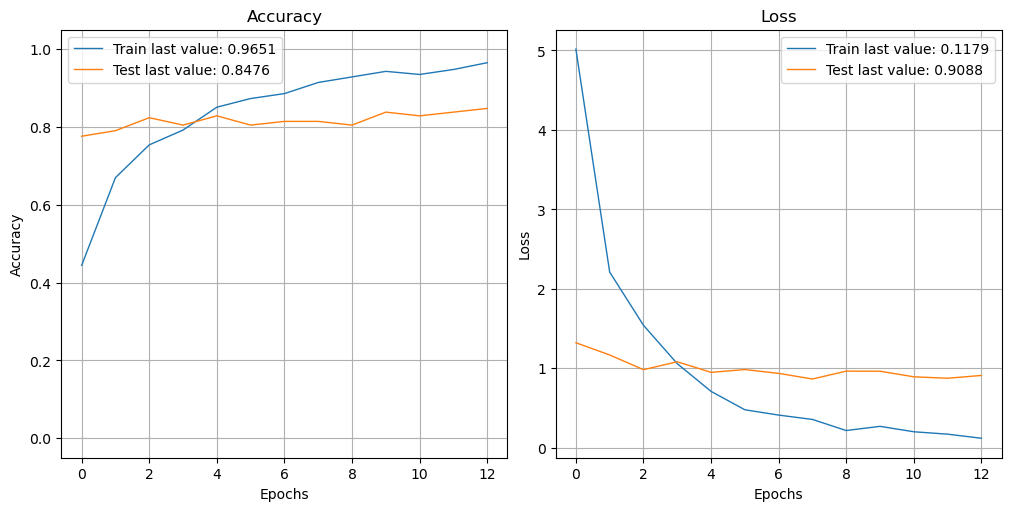

In [17]:
# Entraînement du modèle
model_vgg16, duration_vgg16 = train_model(model_vgg16, X_train_vgg16, y_train, X_val_vgg16, y_val,
                                          model_save_path="./model_vgg16_best.weights.h5")

In [18]:
# Évaluation du modèle
loss_vgg16, accuracy_vgg16, ari_score_vgg16 = evaluate_model(model_vgg16, X_train_vgg16, y_train, X_val_vgg16,
                                                             y_val, X_test_vgg16, y_test, best_weights_path="./model_vgg16_best.weights.h5")

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9942 - loss: 0.0133
Training Accuracy after last epoch: 0.9937

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.7974 - loss: 0.8842
Test Accuracy after last epoch: 0.7857

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.8116 - loss: 0.8810
Validation Accuracy (best): 0.8143
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.7618 - loss: 1.0080
Test Accuracy (best): 0.7762
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
Adjusted Rand Index (ARI): 0.5662


### InceptionResNetV2

In [19]:
# Préparation des données
X_train_inceptionresnetv2, X_val_inceptionresnetv2, X_test_inceptionresnetv2 = prepare_data(paths_train, paths_val,
                                                                                            paths_test, preprocess_inceptionresnetv2,
                                                                                            target_size=(299, 299, 3))

In [20]:
# Création du modèle
model_inceptionresnetv2 = create_model_fct(base_model_name='InceptionResNetV2')

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.4447 - loss: 1.7856
Epoch 1: val_loss improved from inf to 0.63238, saving model to ./model_inceptionresnetv2_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 336ms/step - accuracy: 0.4514 - loss: 1.7646 - val_accuracy: 0.8048 - val_loss: 0.6324
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8259 - loss: 0.6150
Epoch 2: val_loss improved from 0.63238 to 0.44424, saving model to ./model_inceptionresnetv2_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 330ms/step - accuracy: 0.8261 - loss: 0.6139 - val_accuracy: 0.8619 - val_loss: 0.4442
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.8433 - loss: 0.5853
Epoch 3: val_loss did not improve from 0.44424
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step - accuracy: 0.8433 - loss: 0.5830 - val_accuracy: 0.8524 - val_loss: 0.4898
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.8700 - loss: 0.4391
Epoch 4: val_loss did not improve from 0.4

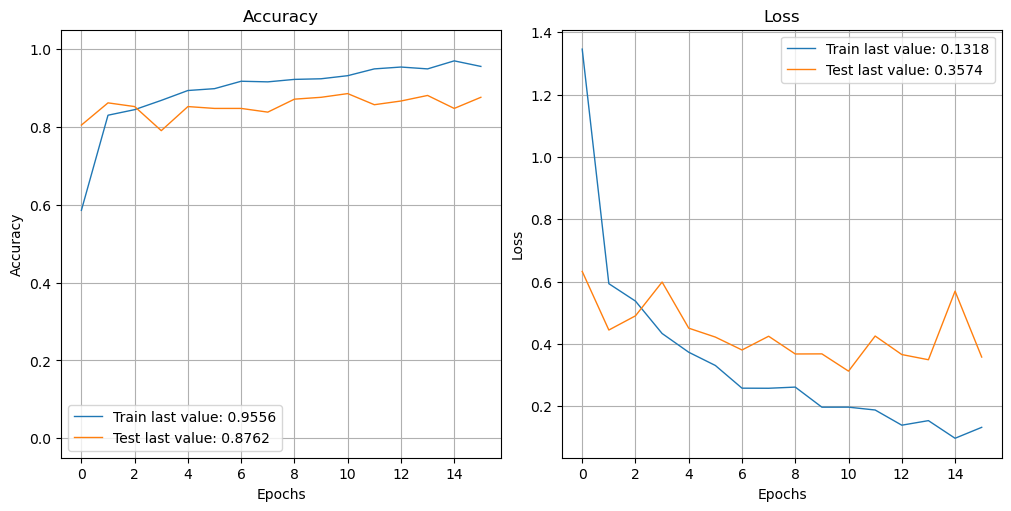

In [21]:
# Entraînement du modèle
model_iresnetv2, duration_iresnetv2 = train_model(model_inceptionresnetv2, X_train_inceptionresnetv2,
                                                  y_train, X_val_inceptionresnetv2, y_val,
                                                  model_save_path="./model_inceptionresnetv2_best.weights.h5")

In [22]:
# Évaluation du modèle
loss_inceptionresnetv2, accuracy_inceptionresnetv2, ari_score_inceptionresnetv2 = evaluate_model(model_iresnetv2,
                                                                                                 X_train_inceptionresnetv2,
                                                                                                 y_train, X_val_inceptionresnetv2,
                                                                                                 y_val, X_test_inceptionresnetv2,
                                                                                                 y_test,
                                                                                                 best_weights_path="./model_inceptionresnetv2_best.weights.h5")

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - accuracy: 0.9806 - loss: 0.0502
Training Accuracy after last epoch: 0.9778

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.9139 - loss: 0.4505
Test Accuracy after last epoch: 0.9000

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.8777 - loss: 0.3296
Validation Accuracy (best): 0.8857
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.9015 - loss: 0.4131
Test Accuracy (best): 0.8905
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step
Adjusted Rand Index (ARI): 0.7811


### DenseNet201

In [23]:
# Préparation des données
X_train_densenet201, X_val_densenet201, X_test_densenet201 = prepare_data(paths_train, paths_val, paths_test,
                                                                          preprocess_densenet201, target_size=(224, 224, 3))


In [24]:
# Création du modèle
model_densenet201 = create_model_fct(base_model_name='DenseNet201')


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.3588 - loss: 2.0547
Epoch 1: val_loss improved from inf to 0.68116, saving model to ./model_densenet201_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 827ms/step - accuracy: 0.3663 - loss: 2.0291 - val_accuracy: 0.7905 - val_loss: 0.6812
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.8136 - loss: 0.6133
Epoch 2: val_loss improved from 0.68116 to 0.65667, saving model to ./model_densenet201_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 820ms/step - accuracy: 0.8138 - loss: 0.6128 - val_accuracy: 0.7857 - val_loss: 0.6567
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.8740 - loss: 0.4928
Epoch 3: val_loss improved from 0.65667 to 0.55781, saving model to ./model_densenet201_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 823ms/step - accuracy: 0.8732 - loss: 0.4926 - val_accuracy: 0.8190 - val_loss: 0.5578
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.8705 - loss: 0

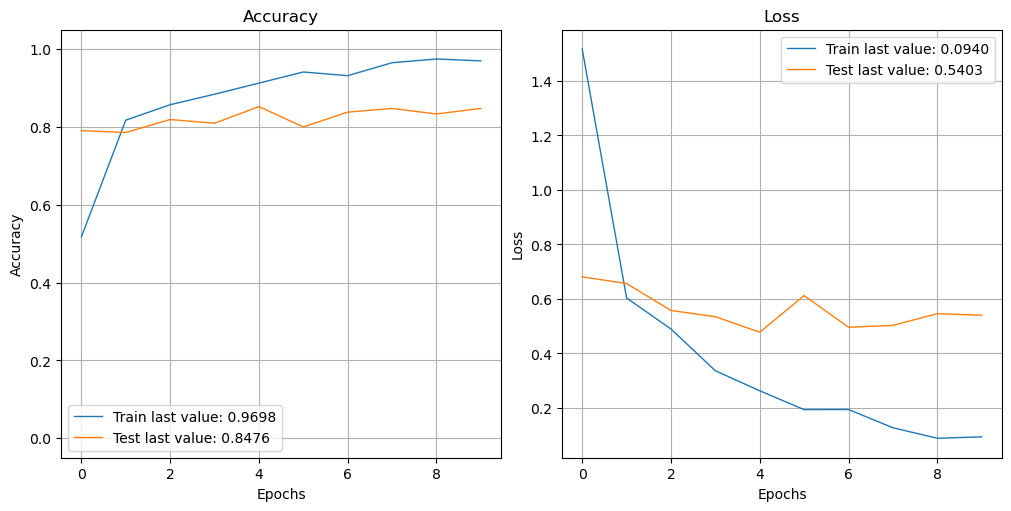

In [25]:
# Entraînement du modèle
model_densenet201, duration_densenet201 = train_model(model_densenet201, X_train_densenet201, y_train,
                                                      X_val_densenet201, y_val,
                                                      model_save_path="./model_densenet201_best.weights.h5")

In [26]:
# Évaluation du modèle
loss_densenet201, accuracy_densenet201, ari_score_densenet201 = evaluate_model(model_densenet201, X_train_densenet201,
                                                                               y_train, X_val_densenet201,
                                                                                y_val, X_test_densenet201, y_test,
                                                                               best_weights_path="./model_densenet201_best.weights.h5")

20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 599ms/step - accuracy: 0.9912 - loss: 0.0235
Training Accuracy after last epoch: 0.9921

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 558ms/step - accuracy: 0.8918 - loss: 0.4728
Test Accuracy after last epoch: 0.8762

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 533ms/step - accuracy: 0.8554 - loss: 0.4977
Validation Accuracy (best): 0.8524
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 535ms/step - accuracy: 0.8781 - loss: 0.4180
Test Accuracy (best): 0.8619
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 547ms/step
Adjusted Rand Index (ARI): 0.7068


### Comparaison des résultats

In [27]:
# Initialisation de la liste pour stocker les résultats
data_results = []

# Fonction pour ajouter les résultats d'un modèle au DataFrame
def add_results(model_name, loss, accuracy, ari_score, duration):
    metrics = ['Loss', 'Accuracy', 'Adjusted Rand Score', 'Duration (en heures)']
    scores = [loss, accuracy, ari_score, (duration/3600)]
    for metric, score in zip(metrics, scores):
        data_results.append({
            'Model': model_name,
            'Metric': metric,
            'Score': score
        })

In [28]:
add_results('VGG16', loss_vgg16, accuracy_vgg16, ari_score_vgg16, duration_vgg16)
add_results('InceptionResNetV2', loss_inceptionresnetv2, accuracy_inceptionresnetv2, ari_score_inceptionresnetv2, duration_iresnetv2)
add_results('DenseNet201', loss_densenet201, accuracy_densenet201, ari_score_densenet201, duration_densenet201)

data_metrics = pd.DataFrame(data_results)

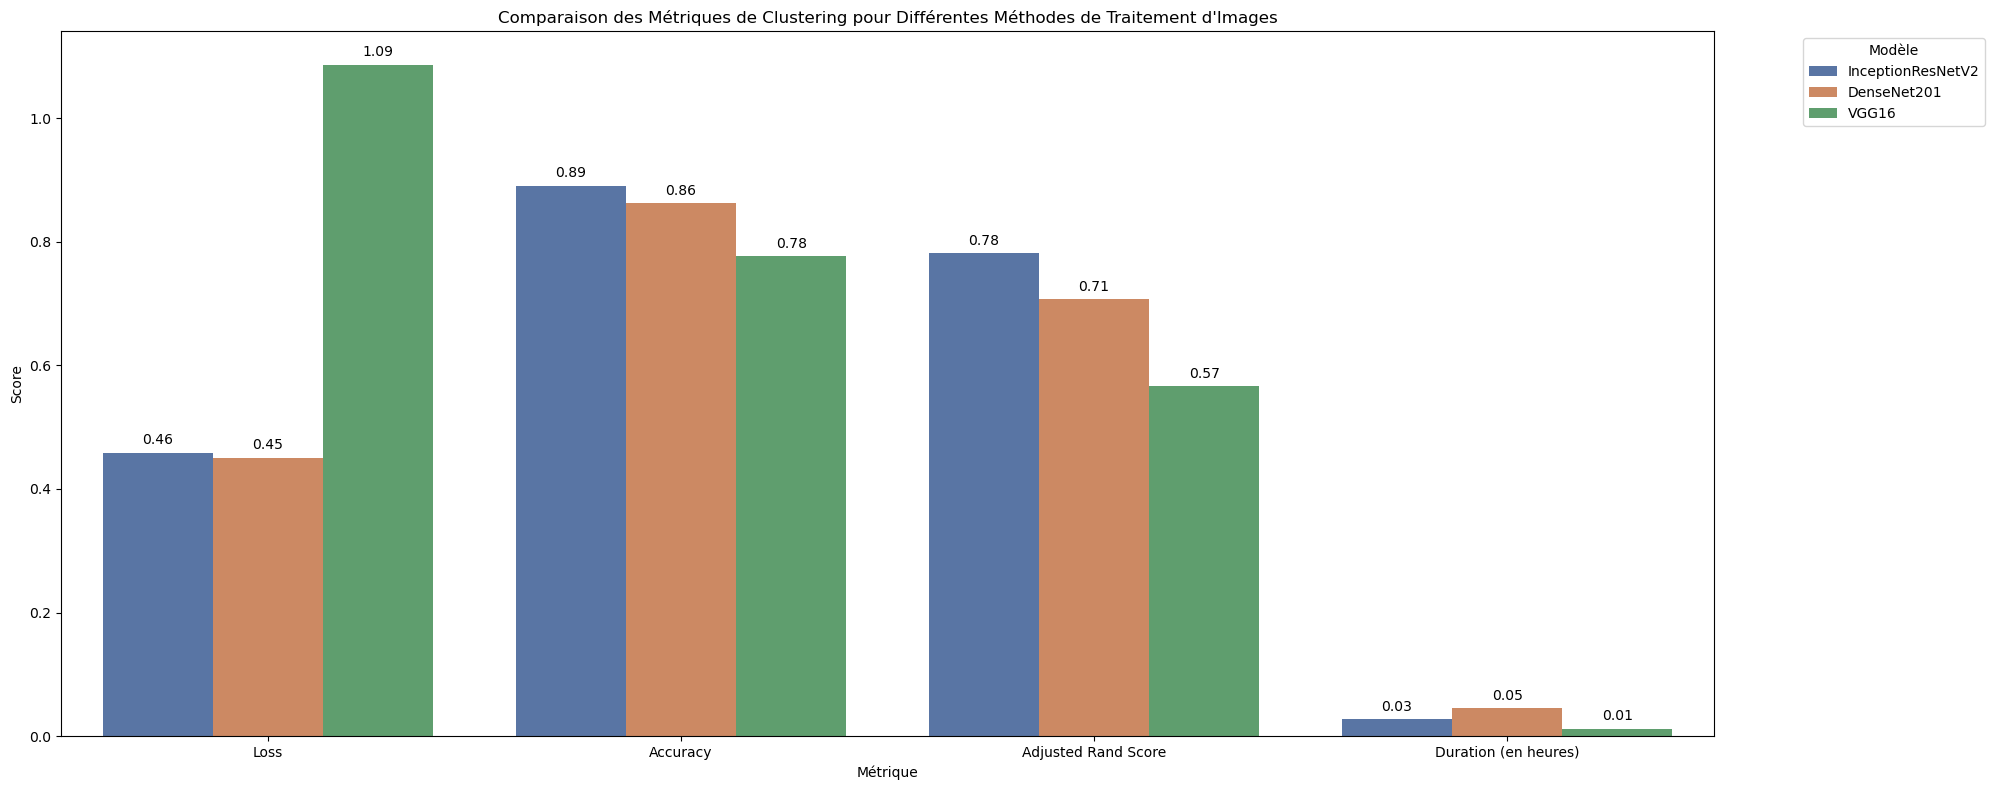

In [29]:
plot_model_performance(data_metrics)

# Optimisation

## Hyper paramètres

In [30]:
# Entraînement du modèle
best_model, duration_best = test_hyperparameters(model_inceptionresnetv2, X_train_inceptionresnetv2, y_train, X_val_inceptionresnetv2,
                                                 y_val, "./model_best.weights.h5")

Testing with learning_rate=0.01, batch_size=16, epochs=50
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 8.
Finished 0.01, 16 with val_accuracy=0.8380952477455139, duration=281.87789392471313
Testing with learning_rate=0.01, batch_size=32, epochs=50
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 8.
Finished 0.01, 32 with val_accuracy=0.8761904835700989, duration=92.21492981910706
Testing with learning_rate=0.01, batch_size=64, epochs=50
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.
Finished 0.01, 64 with val_accuracy=0.8761904835700989, duration=634.4032168388367
Testing with learning_rate=0.001, batch_size=16, epochs=50
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.
Finished 0.001, 16 with val_accuracy=0.8809523582458496, duration=160.39752578735352
Testing with learning_rate=0.001, batch_size=32, epochs=50
Epoch 5: early stopping
Restoring mode

In [31]:
# Évaluation du modèle
loss_best, accuracy_best, ari_score_best = evaluate_model(best_model,
                                                          X_train_inceptionresnetv2,
                                                          y_train, X_val_inceptionresnetv2,
                                                          y_val, X_test_inceptionresnetv2,
                                                          y_test, best_weights_path="none")

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8808 - loss: 0.5781
Validation Accuracy (best): 0.8762
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8963 - loss: 0.6824
Test Accuracy (best): 0.8905
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
Adjusted Rand Index (ARI): 0.7758


In [32]:
add_results('InceptionResNetV2(HP)', loss_best, accuracy_best, ari_score_best, duration_best)
data_metrics = pd.DataFrame(data_results)

In [33]:
data_metrics

,Model,Metric,Score
0,VGG16,Loss,1.086037
1,VGG16,Accuracy,0.776190
2,VGG16,Adjusted Rand Score,0.566190
3,VGG16,Duration (en heures),0.012350
4,InceptionResNetV2,Loss,0.458635
5,InceptionResNetV2,Accuracy,0.890476
6,InceptionResNetV2,Adjusted Rand Score,0.781074
7,InceptionResNetV2,Duration (en heures),0.027221
8,DenseNet201,Loss,0.450721
9,DenseNet201,Accuracy,0.861905


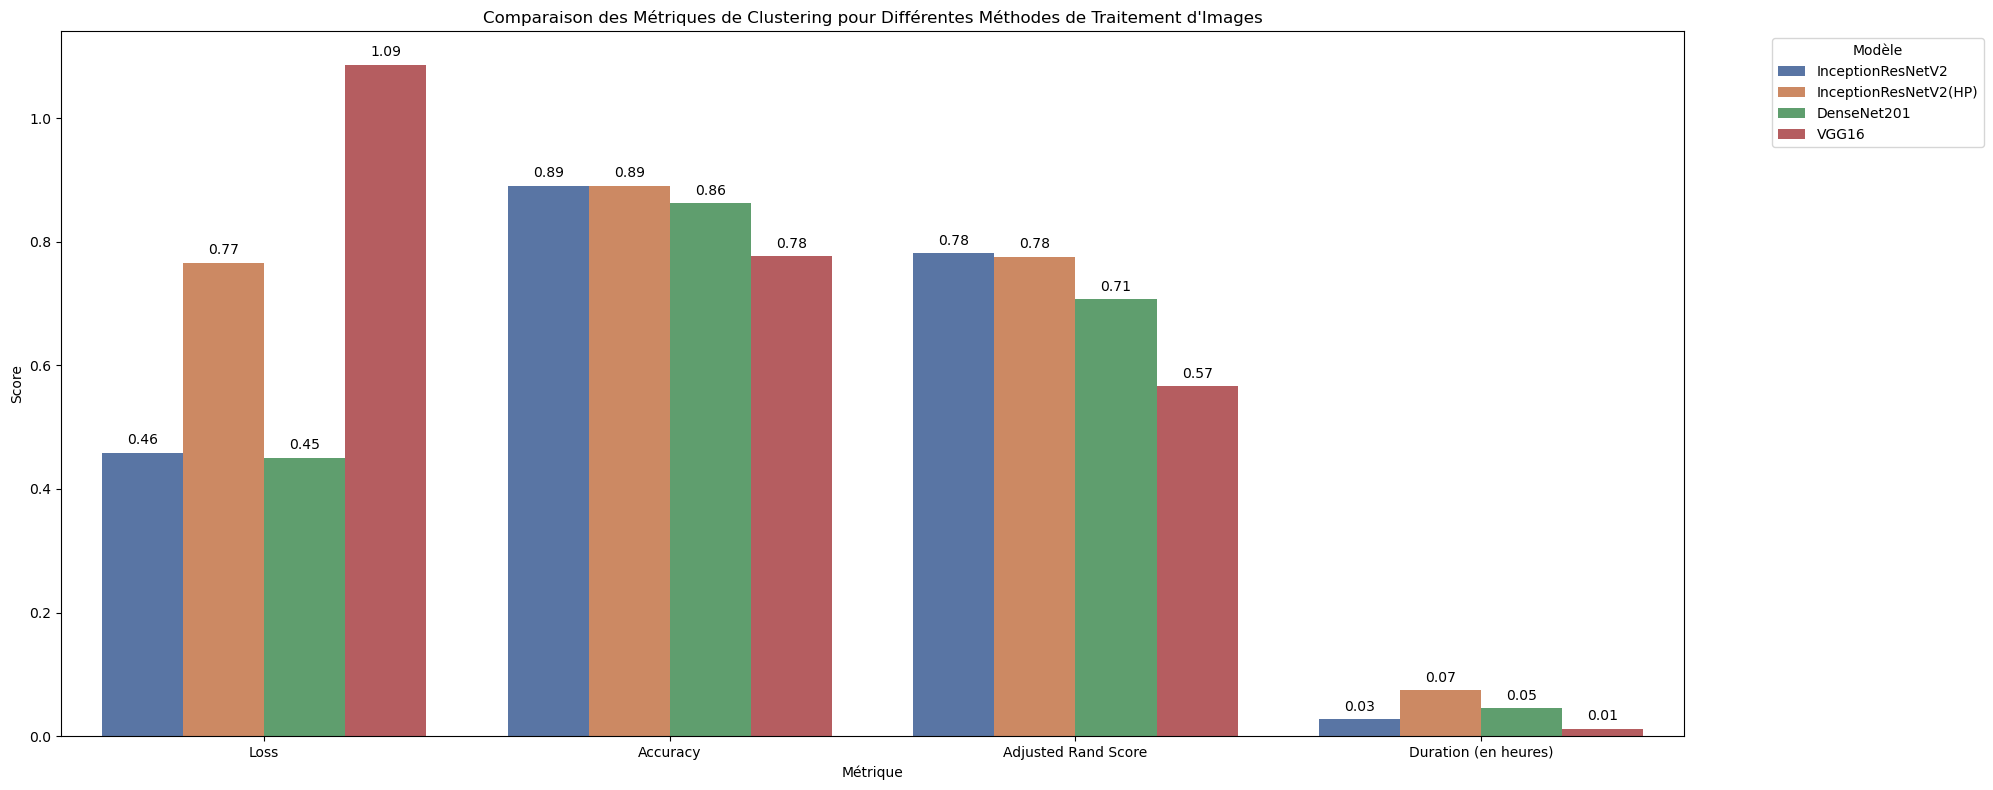

In [34]:
plot_model_performance(data_metrics)

## Data Augmentation

### ImageDataGenerator

In [35]:
train_generator= prepare_augmented_data(X_train_inceptionresnetv2, y_train)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9445 - loss: 0.1830
Epoch 1: val_loss improved from inf to 0.56546, saving model to ./model_augmented_data_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9448 - loss: 0.1830 - val_accuracy: 0.8762 - val_loss: 0.5655
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9545 - loss: 0.2468
Epoch 2: val_loss did not improve from 0.56546
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9551 - loss: 0.2429 - val_accuracy: 0.8905 - val_loss: 0.5761
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9551 - loss: 0.2365
Epoch 3: val_loss did not improve from 0.56546
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9553 - loss: 0.2338 - val_accuracy: 0.8857 - val_loss: 0.6007
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9613 - loss: 0.1102
Epoch 4: val_loss did not improve from 0.56546
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9614 - loss: 0.1116 - val_

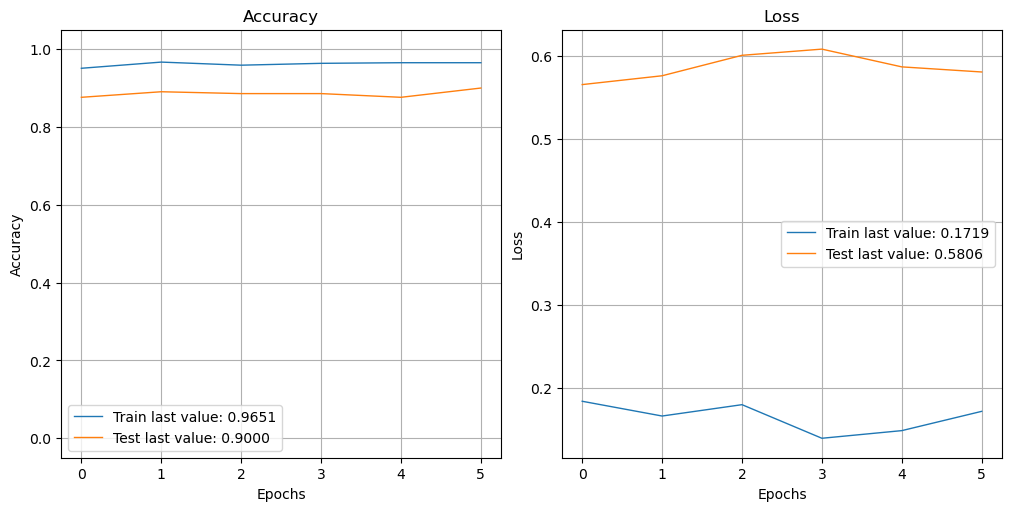

In [36]:
# Entraînement du modèle avec l'approche Sequential
model_augmented,  duration_augmented = train_model(model_iresnetv2,
                                                   train_generator.x, train_generator.y,
                                                   X_val_inceptionresnetv2, y_val,
                                                   "./model_augmented_data_best.weights.h5")

In [37]:
# Évaluation du modèle
loss_augmented, accuracy_augmented, ari_augmented = evaluate_model(model_augmented,train_generator.x, train_generator.y,
                                                                   X_val_inceptionresnetv2, y_val,
                                                                   X_test_inceptionresnetv2, y_test,
                                                                   "./model_augmented_data_best.weights.h5")

20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9869 - loss: 0.0885
Training Accuracy after last epoch: 0.9873

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8786 - loss: 0.7765
Test Accuracy after last epoch: 0.8810

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8786 - loss: 0.6108
Validation Accuracy (best): 0.8762
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8894 - loss: 0.7479
Test Accuracy (best): 0.8857
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
Adjusted Rand Index (ARI): 0.7627


In [38]:
add_results('InceptionResNetV2(ImageDataGenerator)', loss_augmented, accuracy_augmented, ari_augmented,
            duration_augmented)
data_metrics = pd.DataFrame(data_results)

In [39]:
data_metrics

,Model,Metric,Score
0,VGG16,Loss,1.086037
1,VGG16,Accuracy,0.776190
2,VGG16,Adjusted Rand Score,0.566190
3,VGG16,Duration (en heures),0.012350
4,InceptionResNetV2,Loss,0.458635
5,InceptionResNetV2,Accuracy,0.890476
6,InceptionResNetV2,Adjusted Rand Score,0.781074
7,InceptionResNetV2,Duration (en heures),0.027221
8,DenseNet201,Loss,0.450721
9,DenseNet201,Accuracy,0.861905


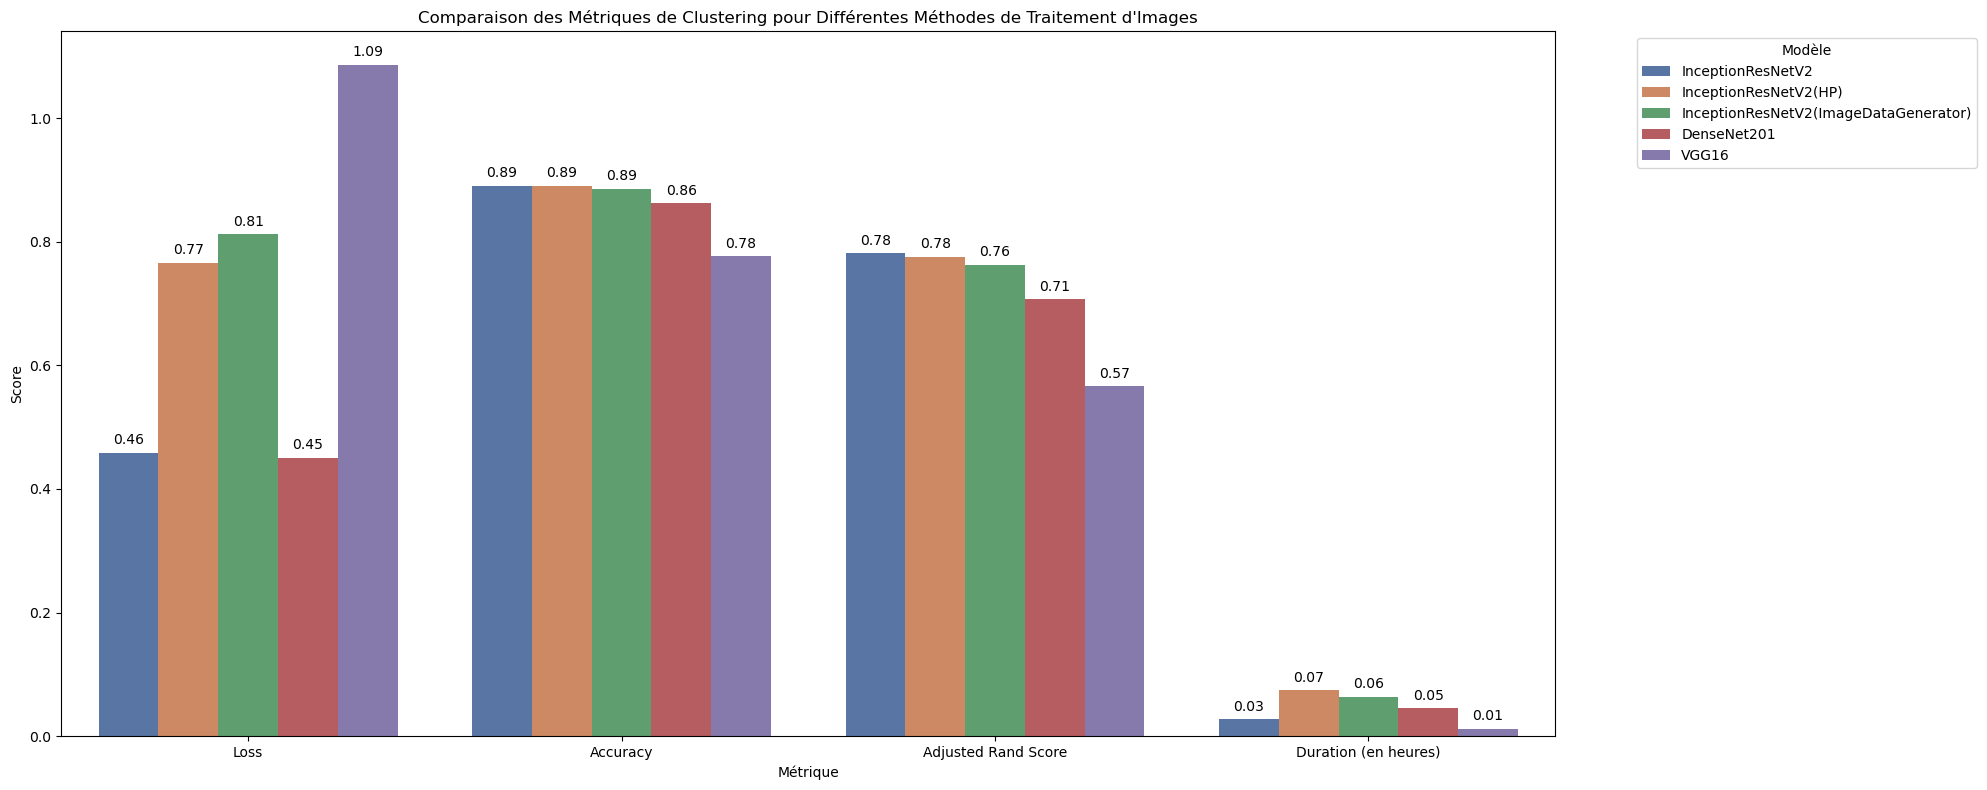

In [40]:
plot_model_performance(data_metrics)

### Sequential

In [41]:
# Création du modèle séquentiel basé sur InceptionResNetV2
sequential_model_inceptionresnetv2 = create_sequential_model()

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2529 - loss: 2.3081
Epoch 1: val_loss improved from inf to 7.71188, saving model to ./model_augmented_data_best_with_seq.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 124s 6s/step - accuracy: 0.2605 - loss: 2.2831 - val_accuracy: 0.1714 - val_loss: 7.7119
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6197 - loss: 1.2439
Epoch 2: val_loss did not improve from 7.71188
20/20 ━━━━━━━━━━━━━━━━━━━━ 123s 6s/step - accuracy: 0.6222 - loss: 1.2349 - val_accuracy: 0.1476 - val_loss: 12.9901
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7856 - loss: 0.6883
Epoch 3: val_loss improved from 7.71188 to 4.55669, saving model to ./model_augmented_data_best_with_seq.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 127s 6s/step - accuracy: 0.7863 - loss: 0.6869 - val_accuracy: 0.2190 - val_loss: 4.5567
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8450 - loss: 0.4365
Epoch 4: val_loss did not improve from 4.556

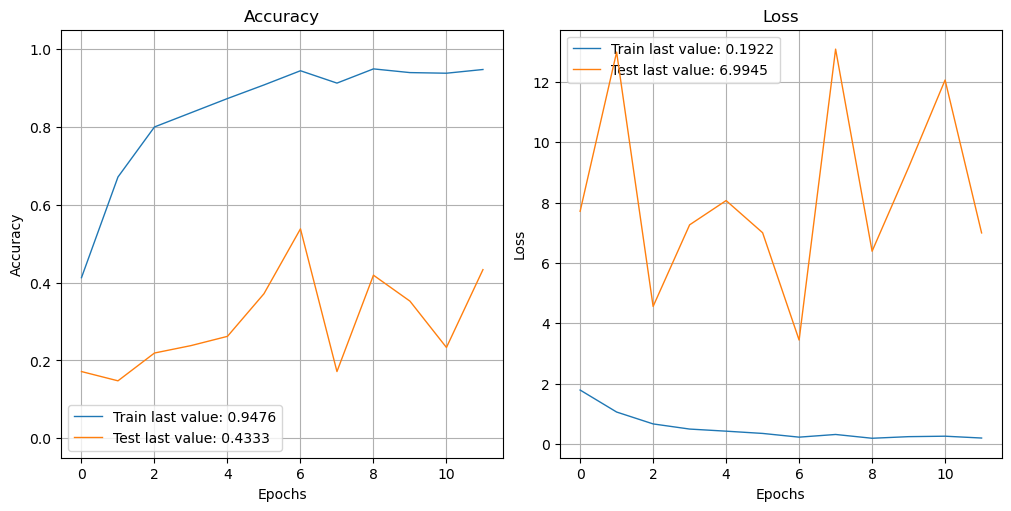

In [42]:
# Entraînement du modèle avec l'approche Sequential
model_with_sequential, duration_with_sequential = train_model(sequential_model_inceptionresnetv2,
                                                              X_train_inceptionresnetv2, y_train,
                                                              X_val_inceptionresnetv2, y_val,
                                                              "./model_augmented_data_best_with_seq.weights.h5")

In [43]:
# Évaluation du modèle
loss_with_sequential, accuracy_with_sequential, ari_score_with_sequential = evaluate_model(sequential_model_inceptionresnetv2,
                                                                                           X_train_inceptionresnetv2, y_train,
                                                                                           X_val_inceptionresnetv2, y_val,
                                                                                           X_test_inceptionresnetv2, y_test,
                                                                                           "./model_augmented_data_best_with_seq.weights.h5")

20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.4622 - loss: 6.4700
Training Accuracy after last epoch: 0.4492

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3692 - loss: 7.8810
Test Accuracy after last epoch: 0.3333

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5459 - loss: 3.2610
Validation Accuracy (best): 0.5381
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6062 - loss: 2.8099
Test Accuracy (best): 0.5952
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
Adjusted Rand Index (ARI): 0.2768


In [44]:
add_results('InceptionResNetV2(Sequential)', loss_with_sequential, accuracy_with_sequential, ari_score_with_sequential,
            duration_with_sequential)
data_metrics = pd.DataFrame(data_results)

In [45]:
data_metrics

,Model,Metric,Score
0,VGG16,Loss,1.086037
1,VGG16,Accuracy,0.776190
2,VGG16,Adjusted Rand Score,0.566190
3,VGG16,Duration (en heures),0.012350
4,InceptionResNetV2,Loss,0.458635
5,InceptionResNetV2,Accuracy,0.890476
6,InceptionResNetV2,Adjusted Rand Score,0.781074
7,InceptionResNetV2,Duration (en heures),0.027221
8,DenseNet201,Loss,0.450721
9,DenseNet201,Accuracy,0.861905


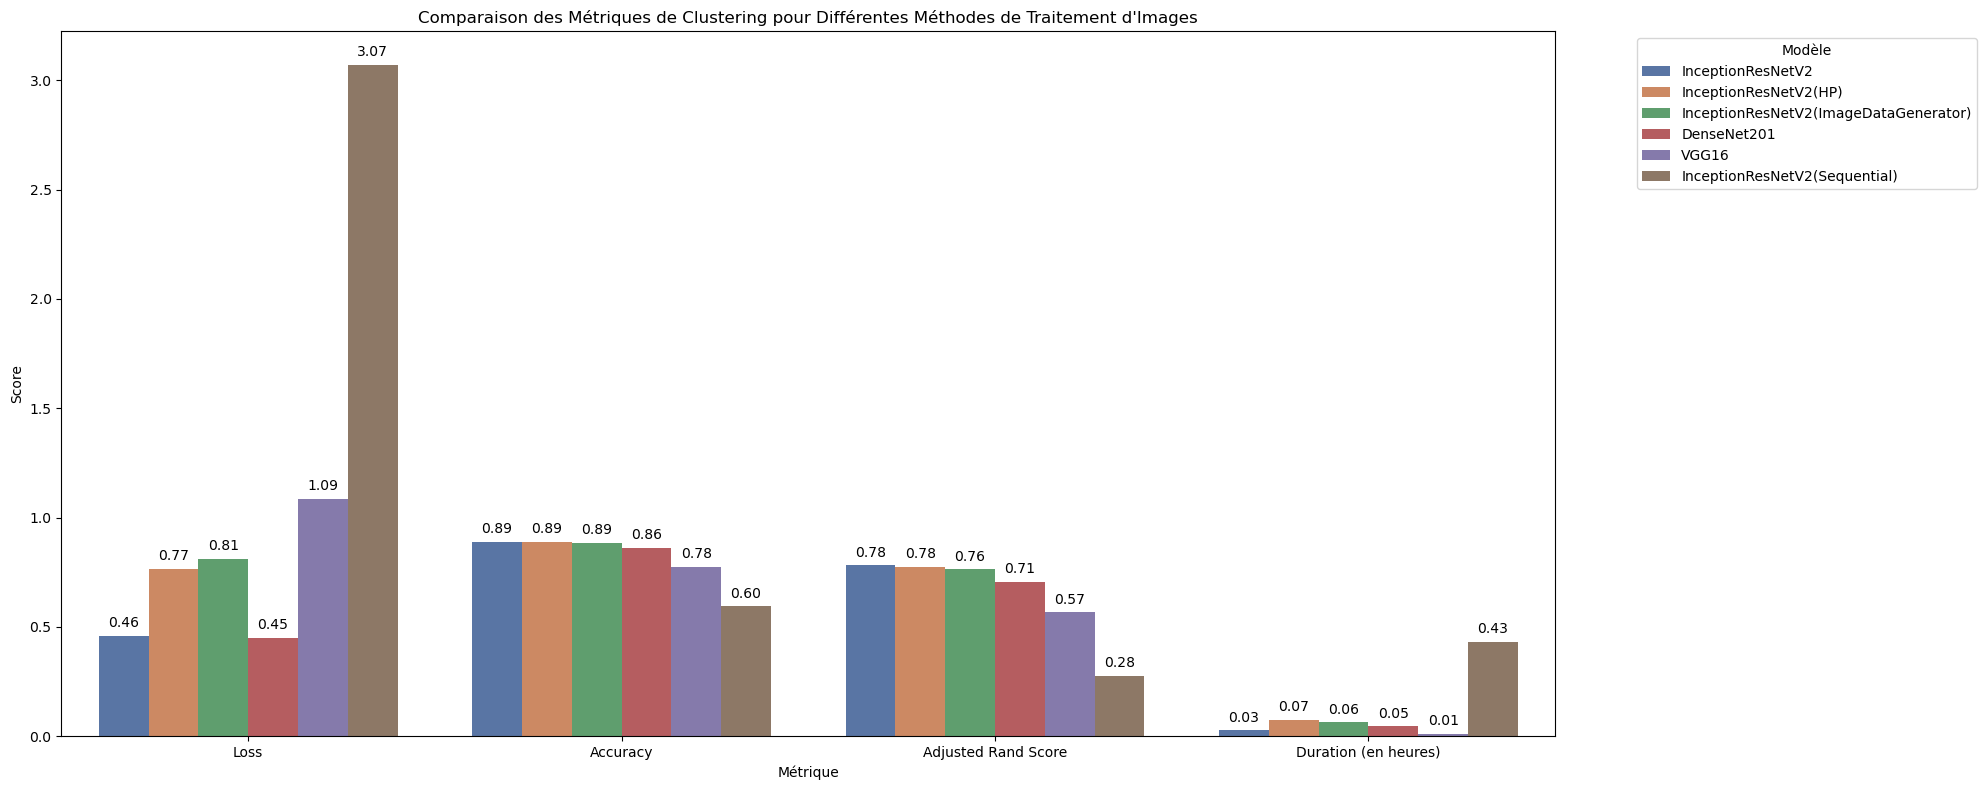

In [46]:
plot_model_performance(data_metrics)

### IA Generative

Utilisation de Copilot et du prompt :
"Créez une image haute résolution de [objet] sur un fond strictement blanc. Le sujet doit être vu de côté, montrant ses formes et caractéristiques distinctives. Assurez-vous que l'éclairage est parfaitement uniforme pour éliminer toutes les ombres sur le sujet et le fond. Le fond doit rester complètement blanc, sans nuances, textures ou autres éléments. L'image doit mettre en valeur uniquement le sujet, idéal pour des présentations de produit."

In [47]:
# Répertoires correspondant aux catégories
repertoires = {
    'Home Furnishing': "./data/Sources/generatedimages/homefurnishing",
    'Baby Care': "./data/Sources/generatedimages/baby",
    'Watches': "./data/Sources/generatedimages/watches",
    'Home Decor & Festive Needs': "./data/Sources/generatedimages/homedecor",
    'Kitchen & Dining': "./data/Sources/generatedimages/kitchen",
    'Beauty and Personal Care': "./data/Sources/generatedimages/beauty",
    'Computers': "./data/Sources/generatedimages/computers"
}

In [48]:
# Initialisation des listes pour les chemins d'image et les étiquettes
paths_train_gen = paths_train.copy()
y_train_gen = y_train.copy()

In [49]:
# Obtenir les catégories dans l'ordre d'encodage
categories = label_encoder.inverse_transform(range(len(label_encoder.classes_)))

# Parcourir tous les répertoires
for categorie, repertoire in repertoires.items():
    # Récupérer l'indice de la catégorie dans l'encodage des catégories
    index_categorie = label_encoder.transform([categorie])[0]

    # Parcourir les images dans le répertoire
    for img in os.listdir(repertoire):
        # Créer le chemin complet de l'image
        chemin_image = os.path.join(repertoire, img)

        # Ajouter le chemin de l'image
        paths_train_gen.append(chemin_image)

        # Créer l'étiquette correspondante pour cette catégorie
        y_imggen_train = np.zeros(7)
        y_imggen_train[index_categorie] = 1

        # Ajouter l'étiquette
        y_train_gen = np.vstack([y_train_gen, y_imggen_train])

# Convertir les listes en tableaux numpy
paths_train_gen = np.array(paths_train_gen)

In [50]:
# Préparation des données
X_train_iresnetv2_ad, X_val_iresnetv2_ad, X_test_iresnetv2_ad = prepare_data(paths_train_gen, paths_val,
                                                                             paths_test, preprocess_inceptionresnetv2,
                                                                             target_size=(299, 299, 3))

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9275 - loss: 0.4023
Epoch 1: val_loss improved from inf to 0.63034, saving model to ./model_iresnetv2_ad_best.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9279 - loss: 0.3978 - val_accuracy: 0.8762 - val_loss: 0.6303
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9394 - loss: 0.2612
Epoch 2: val_loss did not improve from 0.63034
24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9394 - loss: 0.2609 - val_accuracy: 0.8571 - val_loss: 0.6461
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9342 - loss: 0.3324
Epoch 3: val_loss improved from 0.63034 to 0.59606, saving model to ./model_iresnetv2_ad_best.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9346 - loss: 0.3278 - val_accuracy: 0.8619 - val_loss: 0.5961
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9515 - loss: 0.1770
Epoch 4: val_loss did not improve from 0.59606
24/24 ━━━━━━━━━━━━━━━━━

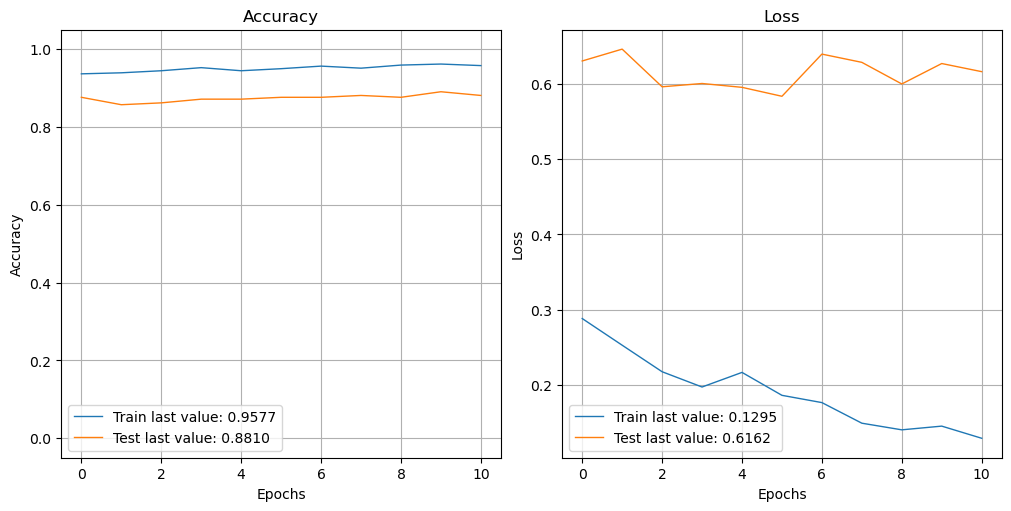

In [51]:
# Entraînement du modèle
model_iresnetv2_ad, duration_iresnetv2_ad = train_model(model_iresnetv2, X_train_iresnetv2_ad,
                                                        y_train_gen, X_val_iresnetv2_ad, y_val,
                                                        model_save_path="./model_iresnetv2_ad_best.weights.h5")

In [52]:
# Évaluation du modèle
loss_iresnetv2_ad, accuracy_iresnetv2_ad, ari_score_iresnetv2_ad = evaluate_model(model_iresnetv2_ad,
                                                                                  X_train_iresnetv2_ad,
                                                                                  y_train_gen, X_val_iresnetv2_ad,
                                                                                  y_val, X_test_iresnetv2_ad,
                                                                                  y_test,
                                                                                  best_weights_path="./model_iresnetv2_ad_best.weights.h5")

24/24 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9885 - loss: 0.0791
Training Accuracy after last epoch: 0.9881

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8910 - loss: 0.7239
Test Accuracy after last epoch: 0.8810

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8808 - loss: 0.6216
Validation Accuracy (best): 0.8762
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8829 - loss: 0.7475
Test Accuracy (best): 0.8810
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
Adjusted Rand Index (ARI): 0.7670


In [53]:
add_results('InceptionResNetV2(IA Generative)', loss_iresnetv2_ad, accuracy_iresnetv2_ad,
            ari_score_iresnetv2_ad, duration_iresnetv2_ad)
data_metrics = pd.DataFrame(data_results)

In [54]:
data_metrics

,Model,Metric,Score
0,VGG16,Loss,1.086037
1,VGG16,Accuracy,0.776190
2,VGG16,Adjusted Rand Score,0.566190
3,VGG16,Duration (en heures),0.012350
4,InceptionResNetV2,Loss,0.458635
5,InceptionResNetV2,Accuracy,0.890476
6,InceptionResNetV2,Adjusted Rand Score,0.781074
7,InceptionResNetV2,Duration (en heures),0.027221
8,DenseNet201,Loss,0.450721
9,DenseNet201,Accuracy,0.861905


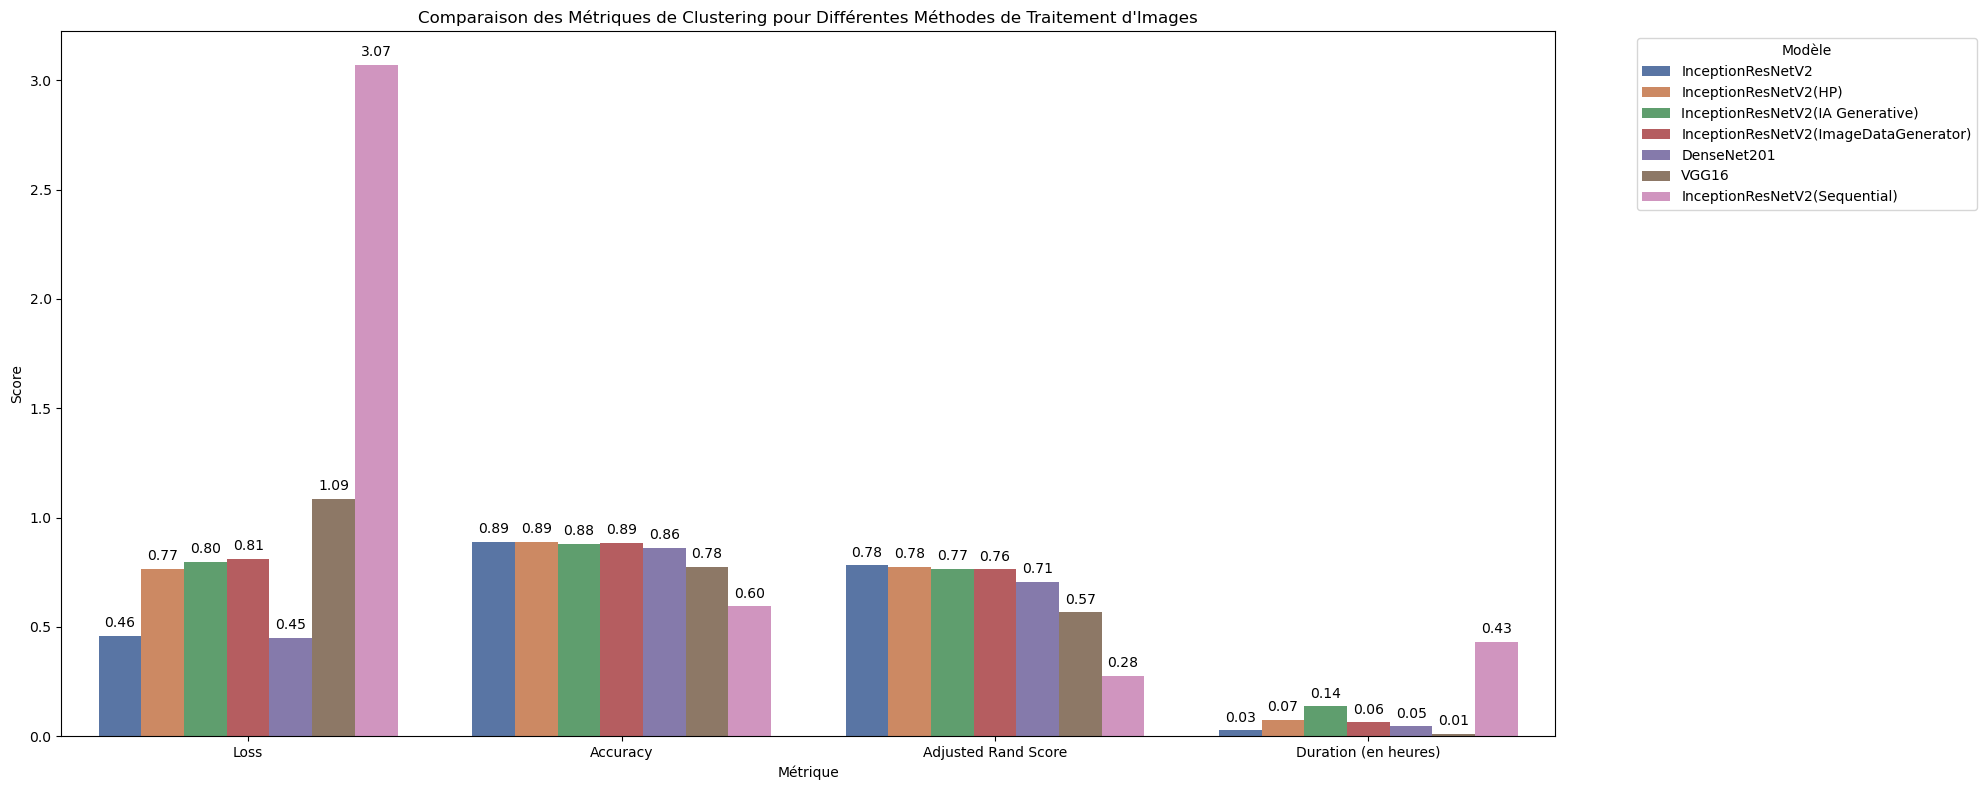

In [55]:
plot_model_performance(data_metrics)